## Determination of the Rate of dT/dt Following Heat Pulse

We want to determine the sap flow velocity based on the evolution of probe temperature in the upstream thermocouple after a heat pulse is applied to a heater downstream of the thermocouple.

To do so, we adopt the solution to the advection-diffusion equation for the evolution of the difference between intial temperature, $T_0$ and the current temperature $T(t)$, which we define as $T^{\prime}(t) = T(t) - T_0$:

$ T^{\prime}(t) = \frac{Q}{4\pi kt}\mbox{exp}\left(\frac{-(x-vt)^2}{4kt}\right)$

We take the derivative of this equation with respect to $t$, which gives us the rate of change of

$\frac{d}{dt} T^{\prime} = -\frac{Q e^{\frac{-(x-vt)^2}{4kt}}
\left(4kt - t^2v^2 - x^2\right)} {16 \pi k^2t^3}$

Setting $d T^{\prime}/dt $ equal to zero and solving for the postivie root of $t$ yields

$ t_{T^{\prime}_{max}} = \frac{-2k + \sqrt{4k^2 + v^2x^2}}{v^2} $

which is the time at which the thermocouple temperature difference is at a maximum following a pulse of heat injected from the heater. 

Operationally, we use these relationships to estimate the velocity of sap flow, $v$, based on monitoring the value of $T^{\prime}$ until we detect the maximum value. We then use the observed value of $ t_{T^{\prime}_{max}}$ to estimate the sap velocity according to

$ v = \frac{\sqrt{=4kt + x^2}}{t} $




In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi, exp

## Probe geometry

We are using a heater probe to inject heat into the xylem and then a thermocouple placed some distance upstream to observe the flow of heat due to advection and diffusion via sap flow and xylem tissue.

The length of the heater, $l$ is taken to be 5.5 cm, and the upstream thermocouple is located at a distance $x_upstream$, taken to be 2.5 cm. We assume that there is no lateral displacement between the thermocouple and the heater (i.e. $y=0$) so that this is 1-d heat flow.

In [125]:
l = 5.5 #  Length of the line heater in cm

x_downstream = 0.0 # distance in xaxis from heater in cm
x_upstream = 2.5 # distance in xaxis from heater in cm
y = 0 # distance in yaxis from heater in cm (assumed to be zero)

## Heat injection via heater probe

The heater liberates an amount of heat per unit length $J$ [J/m], according to the current draw of the heater, $A$, the line voltage, $V$ [V], and the duration of the heat pulse, $t_p$ [sec] according to $J = \frac{Av}{t_p l}$. Typically, $A$ is between 6-7A when v is 12V and $t_p$ is 1 second.

In [126]:
A = 6.5 # The amps drawb by the heater (typically 6-7A for 12V)
v = 12  # Heater voltage (usually 12)
t_p = 1 # Duraction of the pulse in seconds (assume 1 for instant)

In [127]:
# The heat liberated per unit length
J = (A*v)/t_p/l

## Temperature change associated with heat injection

The change temperature, $Q$, caused by an injection of heat, $J$, is affected by the density, $\rho_w$ [g/cm$^3$], and specific heat of water, $C_p$ [J/cm$^3$/K] according to

$Q = J\frac{\rho_w}{C_p}$.

The value of both $\rho_w$ and $C_p$ vary according to xylem temperature 
according to

$C_p = \left(4175+1.66 e^{\frac{34.5-T}{10.6}} + e^{\frac{34.5-T}{10.6}}\right)/1000 $

and 

$\rho_w = \left(1000 - (0.019548*(T-3.98))^{1.68}\right)/1000$


In [128]:
# The temperature to which the amount of heat liberated per unit
# length would raise a unit volume is:
#
# cp_w = 4.186 J/(deg-C g) * 1/rho_w * 1/10^3 [J/(deg-C cm^3)]

In [129]:
from math import exp

T = 20 # Temperature of the xylem in deg-C (assume 20 for now)

rho_w = (1000 - pow(0.019549*(T-3.98),1.68))/1000 # g/cm^3 (Heggen, 1983)

# Specific heat of water in J kg^-1 K^-1, T in deg-C (Heggen, 1983)
cp_w = 4175 + 1.66*(exp((34.5 - T)/10.6) + exp(-1*(34.5 - T)/10.6))
cp_w = cp_w/1000 # J g^-1 K^-1
cp_w = cp_w/rho_w # J [cm^3]^-1 K^-1

Q = J/cp_w

In [130]:
t = np.arange(0.5,1000,0.5) # Time since pulse injection, [sec]
k = 0.003 # Thermal conductivity, cm^2/sec (Marshall, 1958)
sap_velocity = 20 # Sap velocity in cm per hour.
V = sap_velocity/60/60 # Sap velocity in cm/sec

In [131]:
def T_diff(Q,x,t,V=10/60/60,y=0,k=0.003):
    """Temperature difference"""
    from math import pi, exp
    return (Q/(4*pi*k*t))*exp(-(pow(x-V*t,2)-pow(y,2))/(4*k*t))

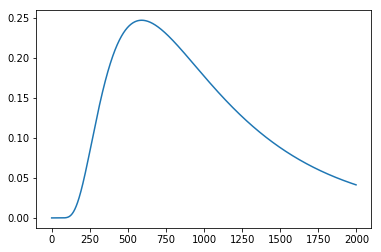

In [132]:
T_diff_upstream=(Q/(4*pi*k*t))*np.exp(-(pow(x_upstream-V*t,2)-pow(y,2))/(4*k*t))
T_diff_heater=(Q/(4*pi*k*t))*np.exp(-(pow(x_downstream-V*t,2)-pow(y,2))/(4*k*t))
df = pd.DataFrame({
    'time':t,
    'upstream':T_diff_upstream,
    'heater':T_diff_heater
})
df.set_index('time')
df['upstream'].plot()
plt.show()

In [133]:
def T_diff_derivative(Q,x,t,V=10/60/60,k=0.003):
    """ Derivative of the temperature difference between heater and probe """
    from math import pi
    return Q*np.exp(-pow((x-t*v),2)/(4*k*t))*(pow(x,2)-t*(4*k+t*pow(v,2)))/(16*pi*pow(k,2)*pow(t^3))

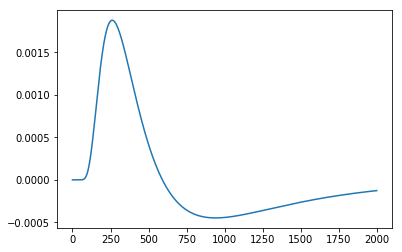

In [134]:
dTdt = Q*np.exp(-pow((x_upstream-t*V),2)/(4*k*t))*(pow(x_upstream,2)-t*(4*k+t*pow(V,2)))/(16*pi*pow(k,2)*pow(t,3))
df = pd.DataFrame({
    'time':t,
    'dTdt': dTdt,
})
df.set_index('time')
df['dTdt'].plot()

In [135]:
def t_max_diff(x,V=10/60/60,k=0.003):
    return (-2*k+pow((4*pow(k,2)+pow(V,2)*pow(x,2)),1/2))/pow(V,2)


def v_from_t_max_diff(t_max,x,V=10/60/60,k=0.003):
    """ Sap velocity as a function of time to max temp diff """
    return (pow(-4*k*t_max+pow(x,2),1/2)/t_max)

In [136]:
t_max = t_max_diff(x_upstream,V,k)
print(v_from_t_max_diff(t_max,x_upstream,V,k))

0.005555555555555554
